# Network burst inference from spike train data (MUA inferences)

In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

mpl_rc = "../assets/matplotlibrc"
plt.style.use(mpl_rc)

import numpy as np
import pandas as pd
from torch import Tensor
from time import time

from automind.sim import b2_interface, runners
from automind.inference import inferer
from automind.utils import data_utils, analysis_utils, dist_utils, plot_utils

---
# Load trained DGM and meta info, and dataset
We first load the trained deep generative model (Normalizing Flow) stored in the `posterior.pickle` file, along with some analysis parameters we need in `params_dict_analysis_updated.pickle`.

As its name suggests, the posterior file contains the trained posterior estimator neural network, constructed using the `sbi` package. The one we use below is particular to the type of data feature we wish to target, i.e., network burst statistics.

In addition, it contains some meta information, like the specific data features it was trained on---and hence must be passed during inference---as well as data preprocessing steps, which must also be applied to the target observation as well.

Unlike the previous demo, we don't need to load the discovered samples dataset, since we're loading and composing the target data from scratch.

In [2]:
data_dirs = "../datasets/discovered_posterior_samples/organoids/"
path_dict = data_utils.extract_data_files(
    data_dirs,
    [
        "posterior.pickle",
        "params_dict_analysis_updated.pickle",
        "summary_data_merged.csv",
    ],
)
_, posterior, params_dict = data_utils.load_df_posteriors(path_dict)
print(posterior)

cols_features = list(posterior.x_bounds_and_transforms.keys())
print("-------------------------")
print(f'Density estimator was trained on these features: {cols_features}')

posterior.pickle ['5065886_posterior.pickle']
params_dict_analysis_updated.pickle ['5065886_MK1_params_dict_analysis_updated.pickle']
summary_data_merged.csv ['5065886_MK1_summary_data_merged.csv']
2502 samples per xo.
Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.
-------------------------
Density estimator was trained on these features: ['burst_interval_mean', 'burst_interval_cv', 'burst_width_mean', 'burst_offset_time_mean']


### Load and process target data from raw spike times
Here, we use another recording from the organoid dataset, and demonstrate how to start from raw spike times to computing summary features amenable to be used for inference.

You can download the `.npz` file [here](https://figshare.com/s/3f1467f8fb0f328aed16) in `./observations`.

In [3]:
# new_data = np.load("../datasets/observations/example_raw_data.npz", allow_pickle=True)
# spikes_in_list, t_end, rec_name, fs = new_data['spikes'], new_data['t_end'], new_data['recording_name'], new_data['fs']
# print(f"Recording {rec_name} was recorded for {t_end} seconds, with a sampling rate of {fs} Hz")

fpath = "../datasets/JT030.pkl"
new_data = np.load(fpath, allow_pickle=True)

# -- metadata
expID = new_data['metadata']['expID']
cell_proportions = new_data['metadata']['cell_proportions']
print(f"Experiment ID: {expID}")
print(f"Cell proportions: {cell_proportions}")

# -- spike times
spikes_in_list = new_data['spike_times']

# manually inputted t_end here
t_end = 600.312  # this is where the spikes were analyzed across
print(f"Recording was recorded for {t_end} seconds")

# convert to samples
fs = 30_000
spikes_in_list = [spikes * fs for spikes in spikes_in_list.values()]

Experiment ID: JT030
Cell proportions: TD20+GV80
Recording was recorded for 600.312 seconds


Spike train data can simply be in the form of a list, where each element contains the spike times of one cell. Timestamps can be in arbitrary units, such as integer indices, as long as the sampling rate to real-time is known (`fs`).

In [4]:
# Print spike times of one cell
spikes_in_list[0]

array([  645902.,  5180266.,  5180276., ..., 40804182., 40804192.,
       40804201.])

In [5]:
spikes_in_list

[array([  645902.,  5180266.,  5180276., ..., 40804182., 40804192.,
        40804201.]),
 array([  644016.,   644026.,   644036.,   644050.,   644060.,   644071.,
         4048579.,  4139533.,  4651806.,  4826399.,  5759443.,  5763295.,
         7190224.,  7376221.,  7409633.,  7636977.,  7686273.,  7686283.,
         7686378.,  7686474.,  7686527.,  7686617.,  7686630.,  7698723.,
         7700501.,  7700568.,  7700581.,  7700591.,  7700602.,  7700620.,
         7700624.,  7700677.,  7700688.,  7700699.,  7700705.,  7715592.,
         7753076.,  7753087.,  7753149.,  7753162.,  7832454.,  7832462.,
         7832467.,  7832562.,  7832571.,  7832587.,  7832612.,  7832622.,
         7832706.,  7832710.,  7832802.,  7832815.,  7866864.,  7866873.,
         7866961.,  7866976.,  7867036.,  7867049.,  7867058.,  7867068.,
         7867125.,  7867138.,  7867215.,  7867226.,  7867236.,  7900684.,
         7900710.,  7900716.,  7900748.,  7900759.,  7900773.,  7900783.,
         7900843.,  790

Next, we convert the list of spikes into the dictionary form, mimicing the simulated data, in order to use the analysis functions as is. Note that this is not necessary, as any custom processing can be used to analyze the data, as long as its final form is what the trained density estimator expects. Although in practice it's recommended to use the same or similar analysis functions and settings, as this will result in better matches to the simulations.

The convenience function `convert_spike_array_to_dict` creates a dictionary from a list of spike "times" and given a sampling rate, resulting in a dictionary with a population `exc_spikes` and spike times in seconds. Then, we can call the analysis function.

In [9]:
spikes_dict = data_utils.convert_spike_array_to_dict(spikes_in_list, fs, 'exc_spikes')
spikes_dict['t_end'] = t_end # end recording time, you can take this as the last spike time plus a little more.

# Analyze data with the same params_dict as the simulated data. 
# Note that depending on your own data, some settings may need to be adjusted in params_dict['params_analysis'].

params_dict['params_analysis']['min_burst_height'] = 1
params_dict['params_analysis']['min_burst_height_ratio'] = 0.1
spikes_analyzed = analysis_utils.compute_spike_burst_features(spikes_dict, params_dict)

This particular analysis computes the total population rate by collapsing across all cells / channels (elements in your original list), and calculates a range of statistics based on the detected network bursts, which uses `scipy.signal.find_peaks` with parameters given by settings in `param_dict`.

We can plot the real data raster and population rate.

In [10]:
spikes_analyzed[2]

{'burst_times': array([256.687, 258.436, 261.087, 262.235, 263.359, 265.423, 267.008]),
 'burst_heights': array([ 590.98008961,  373.72248981,  623.06559643,  624.22421108,
         491.36925687,  128.1417198 , 1076.34611617]),
 'burst_kernels': [array([ 2.2515496 ,  2.3857586 ,  2.48688605, ..., 30.65775858,
         31.78660284, 32.90994629]),
  array([ 1.22360207e+01,  1.22605195e+01,  1.22778996e+01, ...,
         -5.59234658e-06,  2.96694451e-06, -3.83488872e-07]),
  array([ 1.34760103e+01,  1.35696560e+01,  1.36738569e+01, ...,
         -3.58124513e-07, -3.28501484e-07,  1.18878883e-06]),
  array([1.28180699, 1.31108873, 1.31978996, ..., 0.64284263, 0.48539282,
         0.35394226]),
  array([-1.49412058e-05, -1.00449047e-04,  3.95627630e-05, ...,
          7.47098411e-02,  1.17958616e-01,  1.78825871e-01]),
  array([-9.86649681e-09,  1.39897664e-08, -1.58506643e-08, ...,
          5.55776717e-02,  3.29320401e-02,  1.86842464e-02]),
  array([-2.01829423e-04, -2.99122624e-05, -2.6

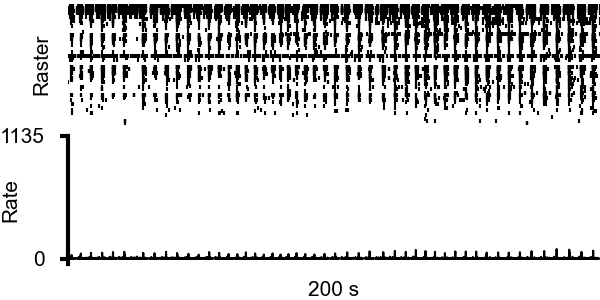

In [11]:
xlims = [0, 200]
fig, axs = plt.subplots(2,1,figsize=(2, 1))
plot_utils._plot_raster_pretty(spikes_dict, plot_inh=False, XL=xlims, every_other=1, fontsize=5, ax=axs[0])
plot_utils._plot_rates_pretty(
        spikes_analyzed[1],
        XL=xlims,        
        pops_to_plot=["avgpop_rate"],
        fontsize=5,
        ax=axs[1],
        color="k",        
    )
axs[1].set_ylabel("Rate", labelpad=-5)
[axs[1].axvline(bt, color='r', ls='--', lw=0.5, alpha=0.4) for bt in spikes_analyzed[2]['burst_times']];

### Define target observation data and apply preprocessing
Element 0 of the output contains a dataframe with all the computed statistics. We further focus on just the ones required by the density estimator for inference.

The target observation then has to undergo a few preprocessing steps, in particular, taking the log of the values to be put on the same scale. These transformations are tracked in the posterior network object (`posterior.x_bounds_and_transforms` and `posterior.x_standardizing_func`), and just need to be applied to the dataset.

If you want to run this demo on a new dataset, you just need to replace `df_xos` with your own pandas dataframe, where each row must contain, among other features, the necessary burst timing features (names printed below). 

Alternatively, it can be supplied as a a numpy array (`xo`), where only the last step is necessary (standardizing and converting to torch tensor).

In [12]:
df_xos = spikes_analyzed[0]
df_xos[cols_features]

,burst_interval_mean,burst_interval_cv,burst_width_mean,burst_offset_time_mean
0,1.720167,0.308216,0.029861,0.015273


In [13]:
df_xos_preproc, _, _, _ = dist_utils.preproc_dataframe(
    df_xos,
    posterior.x_bounds_and_transforms,
    drop_nans=False,
    replace_infs=True,
)
xo = df_xos_preproc.loc[0][cols_features].values
xo_tensor = posterior.x_standardizing_func(Tensor(xo[None, :]))
print(f"Processed target observation has shape {xo_tensor.shape}: {xo_tensor}")

Processed target observation has shape torch.Size([1, 4]): tensor([[-3.4428,  1.7294, -2.9658, -3.0291]])


---
# Inference
Same as last time, this is where the magic happens: we provide the (preprocessed) target observation and draw samples of model configurations that are likely to reproduce this target.

Under the hood, the target is supplied as the conditioner to the conditional Normalizing Flow, which then approximates the posterior distribution given that observation, i.e., $p(parameters|target)$.

Also, we apply the "oversampling" trick here: to acquire `n_samples=5` samples in the end, we first sample by a factor of `oversample_factor=200` more (so 1000 total), and then select the top 5 samples with the highest log-likelihood returned by the Normalizing Flow. This is a fast and cheap operation and encourages samples to be in high-density regions, which empirically helps with finding better data-consistent samples.

For real data, we will be taking more final samples (20 here), since there is typically a 5-25% yield of models that actually result in good matches after simulation.

In [14]:
# Set batch and random seeds
batch_seed = 20241121
data_utils.set_all_seeds(batch_seed)

n_samples = 20
cfg_sample = {
    "name": "demo_NPE",
    "oversample_factor": 200,
    "do_sample_map": False,
    "do_sample_pmean": False,
}

df_samples, samples_dict = inferer.sample_from_posterior(
    posterior=posterior,  # Posterior network
    prior=posterior,  # Need for extracting bounds
    num_samples=n_samples,  # Number of samples to draw
    x_o=xo_tensor,  # Target observation
    cfg_algorithm=cfg_sample,  # Sampling options
)

df_samples

Drawing 4000 posterior samples:   0%|          | 0/4000 [00:00<?, ?it/s]

WARNING    c:\Users\michael.zabolocki\AppData\Local\anaconda3\envs\automind\Lib\site-packages\nflows\transforms\lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:2259.)
  outputs, _ = torch.triangular_solve(
 [py.warnings]
WARNING    c:\users\michael.zabolocki\desktop\code\automind\automind\inference\inferer.py:129: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the rele

,inference.type,infer.log_prob,params_net.exc_prop,params_net.p_e2e,params_net.p_e2i,params_net.p_i2e,params_net.p_i2i,params_net.R_pe2e,params_net.R_Qe2e,params_Epop.p_igniters,...,params_Epop.tau_w,params_Epop.E_gi,params_Epop.Q_ge,params_Epop.Q_gi,params_Epop.tau_ge,params_Epop.tau_gi,params_Epop.poisson_rate,params_Ipop.Q_ge,params_Ipop.Q_gi,params_Ipop.poisson_rate
0,demo_NPE_samples_prune_200,11.436144,0.751674,0.092323,0.066034,0.082583,0.119027,2.013274,1.011024,0.685184,...,18597.689453,-67.430832,4.334961,16.316105,1.997764,4.298731,4.760283,4.608518,14.287761,0.106164
1,demo_NPE_samples_prune_200,11.401884,0.875300,0.067675,0.067277,0.195615,0.126868,4.190817,1.272071,0.772099,...,16716.000000,-77.796005,4.855633,19.240004,4.694664,12.880208,4.881691,2.753353,4.075840,0.419240
2,demo_NPE_samples_prune_200,11.173288,0.731479,0.044341,0.090863,0.153222,0.063875,4.634027,1.638878,0.435878,...,16746.169922,-79.809319,1.432536,4.391226,4.010161,11.725367,2.473983,1.601931,6.528672,0.065105
3,demo_NPE_samples_prune_200,11.112001,0.743313,0.094535,0.018097,0.078252,0.053868,2.956169,1.837493,0.330691,...,3851.864258,-65.520332,3.884602,6.161679,1.728811,9.110678,2.404798,3.521547,10.535521,0.469176
4,demo_NPE_samples_prune_200,11.077608,0.765849,0.017260,0.032458,0.132255,0.074550,4.617898,1.377520,0.678211,...,17045.660156,-80.539627,1.752763,18.453840,18.847095,18.527782,2.722996,2.392548,11.632718,0.406233
5,demo_NPE_samples_prune_200,11.051996,0.840368,0.018947,0.021537,0.166593,0.072136,1.903348,1.423350,0.507733,...,2965.296875,-84.280693,4.234303,19.980429,10.039108,19.526733,0.811474,3.996031,19.327072,0.441797
6,demo_NPE_samples_prune_200,11.039175,0.716893,0.050513,0.070524,0.062560,0.079914,1.703454,1.726401,0.510046,...,13988.957031,-82.211967,2.106533,18.641470,5.557287,4.874856,2.844956,1.907999,5.602223,0.079626
7,demo_NPE_samples_prune_200,10.887030,0.782172,0.027263,0.018824,0.093696,0.069281,4.489284,1.982217,0.889205,...,6496.568359,-80.263313,2.310074,16.645773,9.767510,11.640896,3.512589,2.158510,4.122905,0.596069
8,demo_NPE_samples_prune_200,10.861105,0.776142,0.075029,0.038158,0.122352,0.149954,1.977867,1.334914,0.821191,...,17088.740234,-75.514549,1.425155,14.351011,2.268505,3.101646,4.289006,1.370886,2.140176,0.149870
9,demo_NPE_samples_prune_200,10.760767,0.826551,0.059184,0.056287,0.170954,0.066034,2.247083,1.035044,0.653611,...,15501.922852,-67.464363,3.425027,6.059906,1.933303,11.474961,4.161200,1.863331,5.170069,0.200013


### Visualize model parameters
What do these model configurations look like? 

We can plot their values for each of the 28 different parameters in the clustered-AdEx network, where just these 5 different models already span a large range of values for most of the parameters (each dot below is one of the above sampled configurations). In other words, they exhibit parameter degeneracy / invariance.

For details about the network model and what the parameters mean, see [here](https://www.biorxiv.org/content/10.1101/2024.08.21.608969v1.full.pdf#page=14.17).

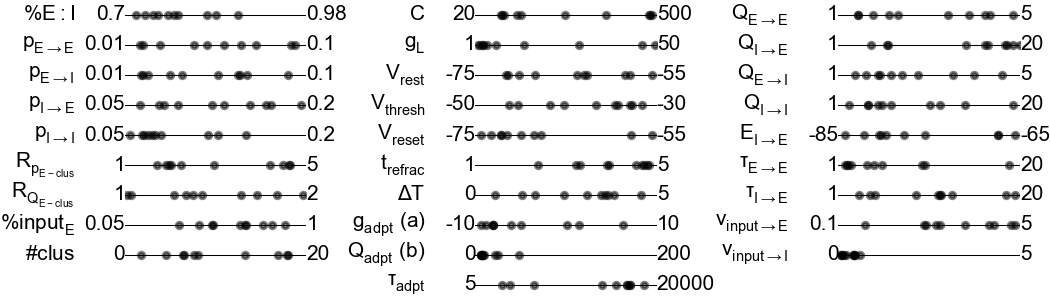

In [15]:
from automind.sim.default_configs import MKI_pretty_param_names

_, theta_minmax = dist_utils.standardize_theta(posterior.prior.sample((1,)), posterior)
fig, axs = plt.subplots(10, 3, figsize=(3.5, 1))
plot_utils.plot_params_1D(
    df_samples[posterior.names].values,
    theta_minmax,
    MKI_pretty_param_names,
    (fig, axs),
    color="k",
    draw_canvas=True,
    draw_kde=False,
    draw_samples=True,
    labelpad=12,
    draw_median=False,
    sample_ms=3,
    sample_alpha=0.5,
);

In [16]:
df_samples.columns

Index(['inference.type', 'infer.log_prob', 'params_net.exc_prop',
       'params_net.p_e2e', 'params_net.p_e2i', 'params_net.p_i2e',
       'params_net.p_i2i', 'params_net.R_pe2e', 'params_net.R_Qe2e',
       'params_Epop.p_igniters', 'params_net.n_clusters', 'params_Epop.C',
       'params_Epop.g_L', 'params_Epop.v_rest', 'params_Epop.v_thresh',
       'params_Epop.v_reset', 'params_Epop.t_refrac', 'params_Epop.delta_T',
       'params_Epop.a', 'params_Epop.b', 'params_Epop.tau_w',
       'params_Epop.E_gi', 'params_Epop.Q_ge', 'params_Epop.Q_gi',
       'params_Epop.tau_ge', 'params_Epop.tau_gi', 'params_Epop.poisson_rate',
       'params_Ipop.Q_ge', 'params_Ipop.Q_gi', 'params_Ipop.poisson_rate'],
      dtype='object')

In [18]:
df_samples['params_net.exc_prop'][0]

np.float64(0.7516736388206482)

In [19]:
df_samples['params_Epop.E_gi'][10]

np.float64(-70.199462890625)

---
# Simulate discovered configurations
Now, we can take those model parameter configurations and simulate them using the clustered AdEx spiking neural network, saving the spike train data and some meta-info.

For the purpose of the demo, we run the simulations in the notebook. However, this does take a long time, especially when multiprocessing doesn't place nice with Jupyter, i.e., as reported for Mac and Windows. Practically, this step is done on a compute cluster, and is highly parallelizeable (1 cpu per simulation). 

In [20]:
# Some housekeeping to set random seed identifiers and set up simulation configurations
# params_dict['params_settings']['batch_seed'] = batch_seed
random_seeds = np.sort(
    np.random.choice(a=int(n_samples * 100), size=n_samples, replace=False)
)
df_samples.insert(loc=0, column="params_settings.batch_seed", value=batch_seed)
df_samples.insert(loc=1, column="params_settings.random_seed", value=random_seeds)

# NOTE: This sets the correct early-stopping condition, i.e., to assess the simulation from 0.1 to 10.1 seconds.
params_dict['params_analysis']['analysis_window'] = [0.1, None] 

params_dict_run = data_utils.fill_params_dict(
    params_dict, df_samples, posterior.as_dict, n_samples
)

params_settings.batch_seed has no prior. Copied as bare value without unit.
params_settings.random_seed has no prior. Copied as bare value without unit.


In [ ]:
cache_path = "./.cache/"
b2_interface.clear_b2_cache(cache_path)
b2_interface.set_b2_cache(cache_path, True)

sim_parallel = True
if sim_parallel:
    from multiprocessing import Pool

    start_time = time()
    with Pool(n_samples) as pool:
        sim_collector = pool.map(runners.adex_simulator, params_dict_run)
    print(f"Simulations took {time()-start_time:.2f} seconds.")
else:
    sim_collector = []
    for i_sim in range(n_samples):
        start_time = time()
        sim_collector.append(runners.adex_simulator(params_dict_run[i_sim]))
        print(f"Simulation {i_sim+1}/{n_samples} took {time()-start_time:.2f} seconds.")

b2_interface.clear_b2_cache(cache_path)

cache non-existent.


### Compute summary features
From the simulation data (spike trains), we can analyze them and extract the same bursting features, as well as smoothed population firing rate over time.

In [ ]:
results_collector = [
    analysis_utils.compute_summary_features(sims[1], sims[0]) for sims in sim_collector
]

### Plot the discovered model simulations
Finally, we plot the simulated spike trains and the population firing rate of each discovered model. 

Note that we will first re-order the simulations based on their similarity to the real data (to show the best models first). We will plot the real data to the right for comparison.

In [ ]:
model_stats = np.ones((n_samples, len(cols_features))) * np.inf
for i_sim, rc in enumerate(results_collector):
    if not rc['summary_bursts'][cols_features].empty:
        model_stats[i_sim, :] = rc['summary_bursts'][cols_features].values

ordered = np.argsort(np.abs(np.log10(model_stats) - xo).sum(axis=1))

In [ ]:
ordered

array([10,  2,  1, 15, 17, 11, 19, 12,  0,  3, 16,  4, 14,  8,  5,  9,  7,
       13,  6, 18])

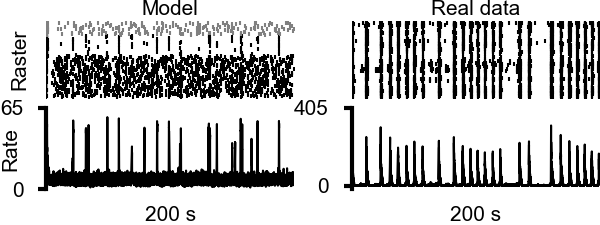

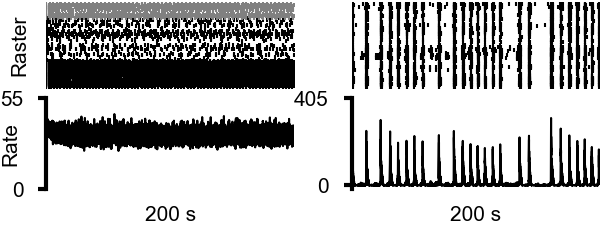

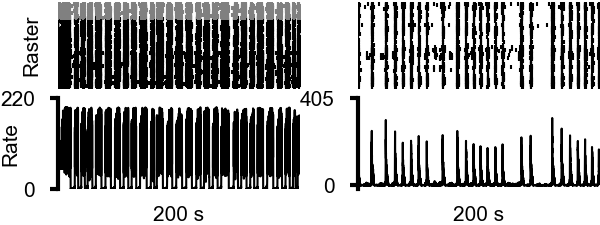

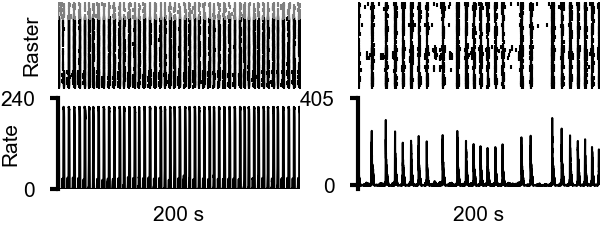

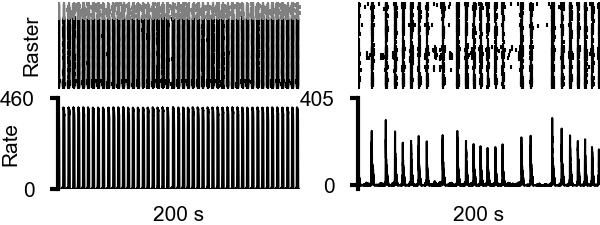

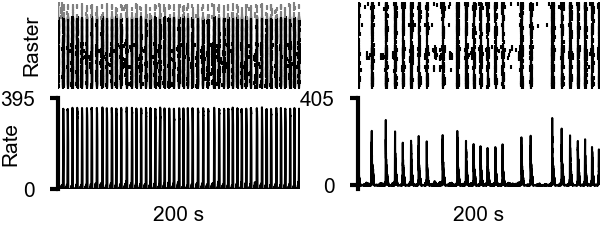

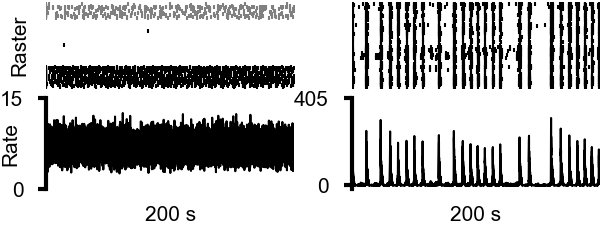

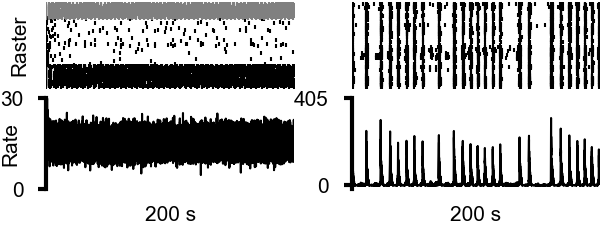

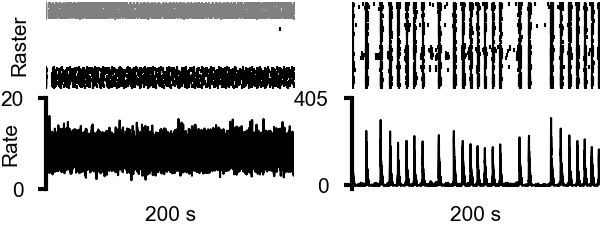

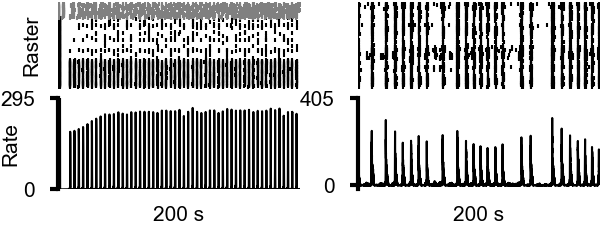

In [ ]:
# Plot the models from best to worst, just plot the first 10
xlims = [0,200]
every_other = 200
for i_, i_sim in enumerate(ordered[:10]):
    fig, axs = plt.subplots(2, 2, figsize=(2, 0.75))
    ax1, ax3, ax2, ax4 = axs.flatten()

    # Plot raster, rates, and PSD
    plot_utils._plot_raster_pretty(
        sim_collector[i_sim][1], XL=xlims, every_other=every_other, fontsize=5, ax=ax1
    )
    plot_utils._plot_rates_pretty(
        results_collector[i_sim]["pop_rates"],
        XL=xlims,
        pops_to_plot=["avgpop_rate"],
        ylim_past=10 * 1000,
        fontsize=5,
        ax=ax2,
        color="k",
    )    
    ax2.set_ylabel("Rate", labelpad=-5)

    # plot real data next to it
    plot_utils._plot_raster_pretty(spikes_dict, XL=xlims, plot_inh=False, every_other=50, fontsize=5, ax=ax3)
    plot_utils._plot_rates_pretty(
            spikes_analyzed[1],
            XL=xlims,        
            pops_to_plot=["avgpop_rate"],
            fontsize=5,
            ax=ax4,
            color="k",        
        )
    ax3.set_ylabel(None); ax4.set_ylabel(None);
    if i_ == 0:
        ax1.set_title(f"Model", fontsize=5, pad=0)
        ax3.set_title(f"Real data", fontsize=5, pad=0)